# Multi-group Agreement (Adult)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Adult
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle
import time

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Adult Dataset
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

## Preprocess and Clean Adult
The Adult dataset is a binary classification task with *categorical* and *numerical* features. We binarize the categorical
features with `OneHotEncoder` and normalize the numerical features with `MinMaxScaler`. We also drop all the rows with missing
features, leaving us with $n = 45,222$ examples total.

In [2]:
# Adult Dataset
adult_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", 
                "income"]
adult_data = pd.read_csv("./datasets/adult/adult.data", header=None, names=adult_names, na_values=' ?')
adult_data = adult_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
adult_test = pd.read_csv("./datasets/adult/adult.test", header=None, names=adult_names, na_values=' ?')
adult_test = adult_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
dfs = [adult_data, adult_test]
adult_df = pd.concat(dfs)
adult_df = adult_df.dropna()
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
print("Adult Shape: {}".format(adult_df.shape))

# last column in adult has some textual discrepancy
adult_df = adult_df.replace(">50K.", ">50K")
adult_df = adult_df.replace("<=50K.", "<=50K")

# Split into X and y
X, y = adult_df.drop("income", axis=1), adult_df["income"]

# Select categorical and numerical features
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variable so we have classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples >=50k (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples <50k (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

Adult Shape: (45222, 15)
% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


In [3]:
def adult_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 'White') & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == race_val) & (df['sex'] == sex_val))

group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
sex_gps = ["Male", "Female"]

# Traditional disjoint groups
for race in race_gps_coarse:
    for sex in sex_gps:
        indices = adult_gp_indices(X, race, sex)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 'White')
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] != 'White')
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['sex'] == 'Male')
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 'Female')
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [4]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (45222, 104)


In [5]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			36177	9045
1 (W,M)			21603	5417
2 (W,F)			9520	2363
3 (nW,M)			2815	692
4 (nW,F)			2239	573
5 (W)			31123	7780
6 (nW)			5054	1265
7 (M)			24418	6109
8 (F)			11759	2936


In [6]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.24378109452736318
P(Y=1 | group 1) = 0.31733431788812994
P(Y=1 | group 2) = 0.12018620397799408
P(Y=1 | group 3) = 0.22687861271676302
P(Y=1 | group 4) = 0.07853403141361257
P(Y=1 | group 5) = 0.25745501285347044
P(Y=1 | group 6) = 0.15968379446640316
P(Y=1 | group 7) = 0.307087903093796
P(Y=1 | group 8) = 0.11205722070844687


## Utilities for Training/Evaluation

In [7]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [8]:
# Construct pairs of groups for "agreement" comparison
erm_group_pairs = list()
group_pairs = list()
group_pairs_cond = list()

# append G0 (ALL) paired with all other groups
for i in range(1, num_groups):
    erm_group_pairs.append((0, i))

# append pairs intersecting at G1 (W,M)
group_pairs.append((1,5))
group_pairs_cond.append(1)
group_pairs.append((5,7))
group_pairs_cond.append(1)
group_pairs.append((1,7))
group_pairs_cond.append(1)

# append pairs intersecting at G2 (W,F)
group_pairs.append((2,5))
group_pairs_cond.append(2)
group_pairs.append((5,8))
group_pairs_cond.append(2)
group_pairs.append((2,8))
group_pairs_cond.append(2)

# append pairs intersecting at G3 (nW,M)
group_pairs.append((3,6))
group_pairs_cond.append(3)
group_pairs.append((6,7))
group_pairs_cond.append(3)
group_pairs.append((3,7))
group_pairs_cond.append(3)

# append pairs intersecting at G4 (nW,F)
group_pairs.append((4,6))
group_pairs_cond.append(4)
group_pairs.append((6,8))
group_pairs_cond.append(4)
group_pairs.append((4,8))
group_pairs_cond.append(4)

# Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [11]:
# Train LogisticRegression models, one per group
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get test errors for each group
lr_test_err = {}
for g in range(num_groups):
    lr_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, lr_test_err[g], std_err(lr_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.1490326147042565 (+/-0.005295510462434083; n=9045)
group 1 (W,M): 0.19198818534244047 (+/-0.0075680098284835315; n=5417)
group 2 (W,F): 0.07829030892932713 (+/-0.00781509420174876; n=2363)
group 3 (nW,M): 0.14017341040462428 (+/-0.01866380576739398; n=692)
group 4 (nW,F): 0.059336823734729496 (+/-0.013957797908572664; n=573)
group 5 (W): 0.15694087403598972 (+/-0.005832063577890563; n=7780)
group 6 (nW): 0.10118577075098814 (+/-0.01199124915107631; n=1265)
group 7 (M): 0.18677361270256998 (+/-0.007051693473778184; n=6109)
group 8 (F): 0.07356948228882834 (+/-0.006813844975828256; n=2936)


In [12]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
lr_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    lr_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(W,M, W) agreement on G1 (W,M):	0.9909544028059811
(W, M) agreement on G1 (W,M):	0.9900313826841425
(W,M, M) agreement on G1 (W,M):	0.9942772752446003
(W,F, W) agreement on G2 (W,F):	0.9877274650867541
(W, F) agreement on G2 (W,F):	0.9898434193821414
(W,F, F) agreement on G2 (W,F):	0.9953449005501481
(nW,M, nW) agreement on G3 (nW,M):	0.9725433526011561
(nW, M) agreement on G3 (nW,M):	0.9710982658959537
(nW,M, M) agreement on G3 (nW,M):	0.9696531791907514
(nW,F, nW) agreement on G4 (nW,F):	0.9720767888307156
(nW, F) agreement on G4 (nW,F):	0.9825479930191972
(nW,F, F) agreement on G4 (nW,F):	0.9825479930191972

(ALL, W,M) agreement:	0.9618573797678275
(ALL, W,F) agreement:	0.8442233278054173
(ALL, nW,M) agreement:	0.9485903814262023
(ALL, nW,F) agreement:	0.9216141514648978
(ALL, W) agreement:	0.9857379767827529
(ALL, nW) agreement:	0.9624101713653952
(ALL, M) agreement:	0.9710337202874516
(ALL, F) agreement:	0.8487562189054726


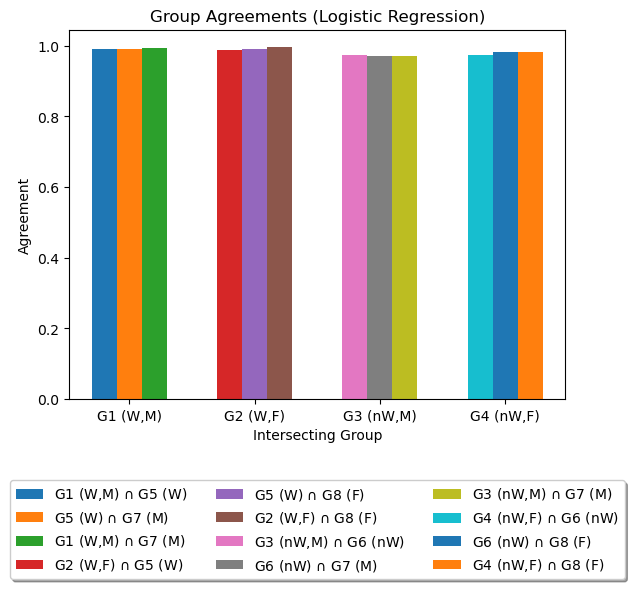

In [13]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, lr_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, lr_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, lr_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, lr_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, lr_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, lr_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, lr_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, lr_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, lr_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, lr_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, lr_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, lr_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Decision Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

dt_test_err = {}
for g in range(num_groups):
    dt_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, dt_test_err[g], std_err(dt_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.14228855721393036 (+/-0.005194769740701443; n=9045)
group 1 (W,M): 0.18737308473324718 (+/-0.007497816108126731; n=5417)
group 2 (W,F): 0.07151925518408803 (+/-0.007496888976549171; n=2363)
group 3 (nW,M): 0.14017341040462428 (+/-0.01866380576739398; n=692)
group 4 (nW,F): 0.06457242582897033 (+/-0.014519990150373878; n=573)
group 5 (W): 0.1582262210796915 (+/-0.005851431482683345; n=7780)
group 6 (nW): 0.10434782608695652 (+/-0.012155732379760269; n=1265)
group 7 (M): 0.18415452610901947 (+/-0.007013343142461465; n=6109)
group 8 (F): 0.07050408719346049 (+/-0.00668140598132206; n=2936)


In [16]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
dt_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    dt_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(W,M, W) agreement on G1 (W,M):	0.9553258261030091
(W, M) agreement on G1 (W,M):	0.9844932619531106
(W,M, M) agreement on G1 (W,M):	0.9638176112239247
(W,F, W) agreement on G2 (W,F):	0.9724925941599661
(W, F) agreement on G2 (W,F):	0.9712230215827338
(W,F, F) agreement on G2 (W,F):	0.9970376639864579
(nW,M, nW) agreement on G3 (nW,M):	0.976878612716763
(nW, M) agreement on G3 (nW,M):	0.9812138728323699
(nW,M, M) agreement on G3 (nW,M):	0.9725433526011561
(nW,F, nW) agreement on G4 (nW,F):	0.9685863874345549
(nW, F) agreement on G4 (nW,F):	0.9790575916230366
(nW,F, F) agreement on G4 (nW,F):	0.9650959860383944

(ALL, W,M) agreement:	0.9754560530679933
(ALL, W,F) agreement:	0.8640132669983416
(ALL, nW,M) agreement:	0.9285793255942509
(ALL, nW,F) agreement:	0.8567164179104477
(ALL, W) agreement:	0.9722498618021006
(ALL, nW) agreement:	0.953012714206744
(ALL, M) agreement:	0.9600884466556109
(ALL, F) agreement:	0.8721945826423438


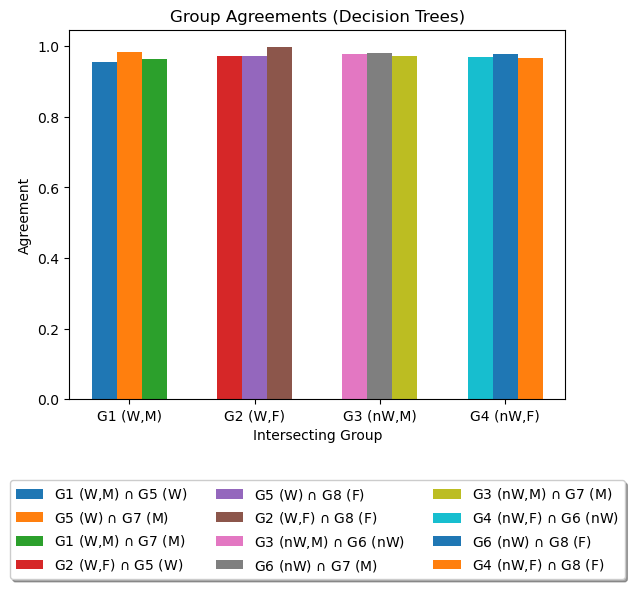

In [17]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, dt_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, dt_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, dt_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, dt_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, dt_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, dt_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, dt_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, dt_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, dt_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, dt_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, dt_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, dt_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Gradient-Boosted Trees

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

gb_test_err = {}
for g in range(num_groups):
    gb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, gb_test_err[g], std_err(gb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.12924267551133223 (+/-0.004988411254187812; n=9045)
group 1 (W,M): 0.17057411851578363 (+/-0.007227380828345427; n=5417)
group 2 (W,F): 0.06601777401608125 (+/-0.007224085562431033; n=2363)
group 3 (nW,M): 0.12283236994219653 (+/-0.017646544048870536; n=692)
group 4 (nW,F): 0.055846422338568937 (+/-0.013566152245142996; n=573)
group 5 (W): 0.13791773778920308 (+/-0.005528529311456888; n=7780)
group 6 (nW): 0.09723320158102766 (+/-0.011780529665332544; n=1265)
group 7 (M): 0.16532984121787528 (+/-0.006721450474964076; n=6109)
group 8 (F): 0.0653950953678474 (+/-0.006452434265404928; n=2936)


In [20]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
gb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    gb_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,M, W) agreement on G1 (W,M):	0.985600886099317
(W, M) agreement on G1 (W,M):	0.9843086579287429
(W,M, M) agreement on G1 (W,M):	0.9902159867085103
(W,F, W) agreement on G2 (W,F):	0.9877274650867541
(W, F) agreement on G2 (W,F):	0.9873042742276766
(W,F, F) agreement on G2 (W,F):	0.9911129919593736
(nW,M, nW) agreement on G3 (nW,M):	0.9609826589595376
(nW, M) agreement on G3 (nW,M):	0.9436416184971098
(nW,M, M) agreement on G3 (nW,M):	0.9566473988439307
(nW,F, nW) agreement on G4 (nW,F):	0.9842931937172775
(nW, F) agreement on G4 (nW,F):	0.9825479930191972
(nW,F, F) agreement on G4 (nW,F):	0.987783595113438

(ALL, W,M) agreement:	0.9625207296849088
(ALL, W,F) agreement:	0.8880044223327805
(ALL, nW,M) agreement:	0.9269209508015478
(ALL, nW,F) agreement:	0.8556108347153123
(ALL, W) agreement:	0.9690436705362079
(ALL, nW) agreement:	0.9389718076285241
(ALL, M) agreement:	0.960530679933665
(ALL, F) agreement:	0.8810392482034273


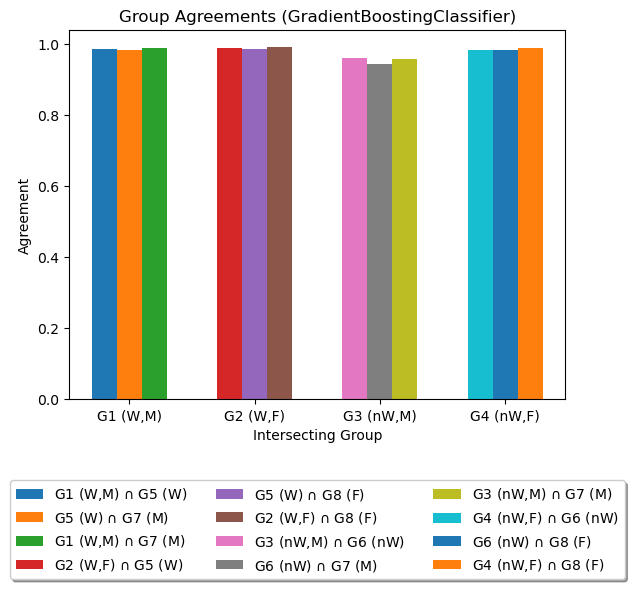

In [21]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, gb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, gb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, gb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, gb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, gb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, gb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, gb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, gb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, gb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, gb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, gb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, gb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (GradientBoostingClassifier)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# XGBoost

In [22]:
from xgboost import XGBClassifier

In [23]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

xgb_test_err = {}
for g in range(num_groups):
    xgb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, xgb_test_err[g], std_err(xgb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.13012714206744058 (+/-0.005002908362872241; n=9045)
group 1 (W,M): 0.1679896621746354 (+/-0.007183584747175932; n=5417)
group 2 (W,F): 0.06771053745239103 (+/-0.007309482914285193; n=2363)
group 3 (nW,M): 0.12427745664739884 (+/-0.017735416578253768; n=692)
group 4 (nW,F): 0.06108202443280977 (+/-0.014148429167305701; n=573)
group 5 (W): 0.137146529562982 (+/-0.005515515833348758; n=7780)
group 6 (nW): 0.091699604743083 (+/-0.011475410193262332; n=1265)
group 7 (M): 0.16221967588803404 (+/-0.00667032167440799; n=6109)
group 8 (F): 0.06471389645776567 (+/-0.006421078626222198; n=2936)


In [24]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
xgb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    xgb_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,M, W) agreement on G1 (W,M):	0.969724940003692
(W, M) agreement on G1 (W,M):	0.9739708325641498
(W,M, M) agreement on G1 (W,M):	0.9857854901236847
(W,F, W) agreement on G2 (W,F):	0.9792636479052053
(W, F) agreement on G2 (W,F):	0.9830723656369023
(W,F, F) agreement on G2 (W,F):	0.9902666102412188
(nW,M, nW) agreement on G3 (nW,M):	0.9393063583815029
(nW, M) agreement on G3 (nW,M):	0.953757225433526
(nW,M, M) agreement on G3 (nW,M):	0.9421965317919075
(nW,F, nW) agreement on G4 (nW,F):	0.9912739965095986
(nW, F) agreement on G4 (nW,F):	0.9808027923211169
(nW,F, F) agreement on G4 (nW,F):	0.9755671902268761

(ALL, W,M) agreement:	0.9630735212824765
(ALL, W,F) agreement:	0.8786069651741294
(ALL, nW,M) agreement:	0.9295743504698729
(ALL, nW,F) agreement:	0.8595909342177999
(ALL, W) agreement:	0.9826423438363737
(ALL, nW) agreement:	0.9509121061359868
(ALL, M) agreement:	0.9641791044776119
(ALL, F) agreement:	0.886456605859591


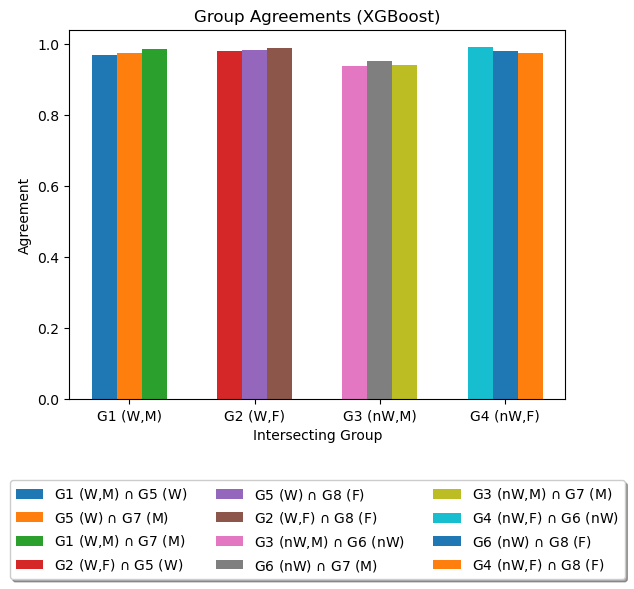

In [25]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, xgb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, xgb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, xgb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, xgb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, xgb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, xgb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, xgb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, xgb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, xgb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, xgb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, xgb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, xgb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostClassifier

In [27]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

ada_test_err = {}
for g in range(num_groups):
    ada_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, ada_test_err[g], std_err(ada_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.14118297401879493 (+/-0.00517788258598975; n=9045)
group 1 (W,M): 0.1803581318072734 (+/-0.007387806489926905; n=5417)
group 2 (W,F): 0.07194244604316546 (+/-0.0075173226667870595; n=2363)
group 3 (nW,M): 0.13005780346820808 (+/-0.01808320295121033; n=692)
group 4 (nW,F): 0.055846422338568937 (+/-0.013566152245142996; n=573)
group 5 (W): 0.1461439588688946 (+/-0.00566380067499941; n=7780)
group 6 (nW): 0.10513833992094862 (+/-0.012196304073073557; n=1265)
group 7 (M): 0.17531510885578655 (+/-0.006879923783935992; n=6109)
group 8 (F): 0.0681198910081744 (+/-0.00657588130132432; n=2936)


In [28]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
ada_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    ada_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(W,M, W) agreement on G1 (W,M):	0.9660328595163374
(W, M) agreement on G1 (W,M):	0.976001476832195
(W,M, M) agreement on G1 (W,M):	0.9771091009784013
(W,F, W) agreement on G2 (W,F):	0.9754549301735083
(W, F) agreement on G2 (W,F):	0.9767245027507406
(W,F, F) agreement on G2 (W,F):	0.9911129919593736
(nW,M, nW) agreement on G3 (nW,M):	0.9508670520231214
(nW, M) agreement on G3 (nW,M):	0.9624277456647399
(nW,M, M) agreement on G3 (nW,M):	0.9335260115606936
(nW,F, nW) agreement on G4 (nW,F):	0.9912739965095986
(nW, F) agreement on G4 (nW,F):	0.9825479930191972
(nW,F, F) agreement on G4 (nW,F):	0.987783595113438

(ALL, W,M) agreement:	0.9594250967385296
(ALL, W,F) agreement:	0.8741846323935876
(ALL, nW,M) agreement:	0.9336650082918739
(ALL, nW,F) agreement:	0.8790491984521835
(ALL, W) agreement:	0.9876174682144832
(ALL, nW) agreement:	0.9559977888336098
(ALL, M) agreement:	0.9720287451630735
(ALL, F) agreement:	0.8760641238253178


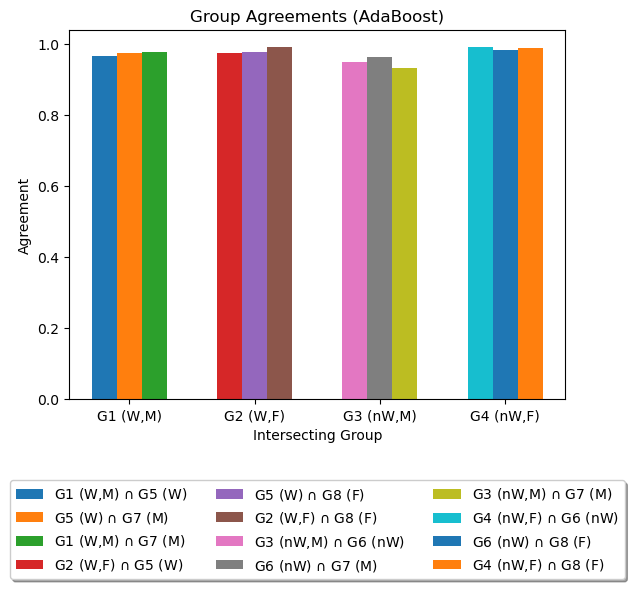

In [29]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, ada_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, ada_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, ada_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, ada_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, ada_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, ada_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, ada_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, ada_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, ada_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, ada_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, ada_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, ada_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# All Together, Now

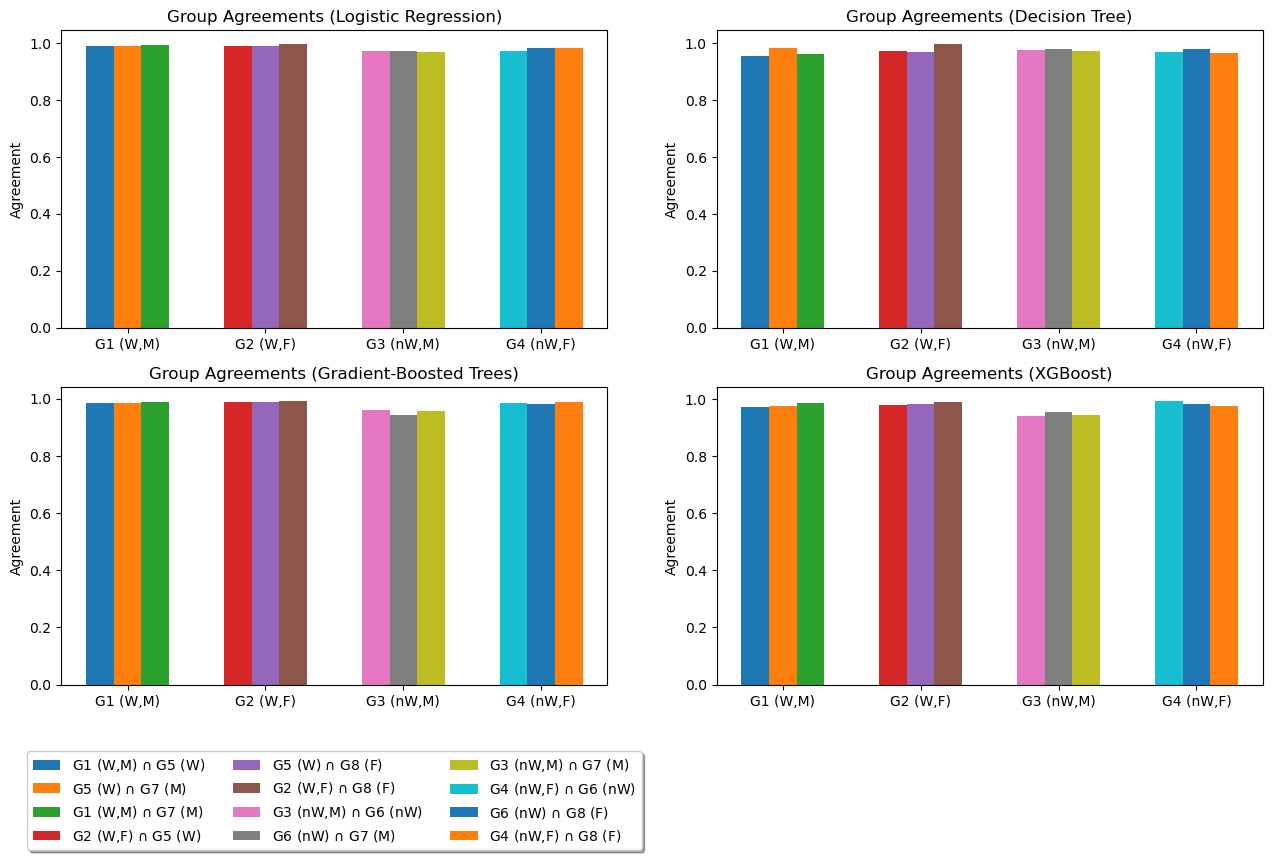

In [30]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

# LOGISTIC REGRESSION
rect11 = ax[0][0].bar(0 - bar_width, lr_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[0][0].bar(0, lr_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[0][0].bar(0 + bar_width, lr_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[0][0].bar(1 - bar_width, lr_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[0][0].bar(1, lr_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[0][0].bar(1 + bar_width, lr_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[0][0].bar(2 - bar_width, lr_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[0][0].bar(2, lr_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[0][0].bar(2 + bar_width, lr_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[0][0].bar(3 - bar_width, lr_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[0][0].bar(3, lr_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[0][0].bar(3 + bar_width, lr_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# DECISION TREE
rect11 = ax[0][1].bar(0 - bar_width, dt_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[0][1].bar(0, dt_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[0][1].bar(0 + bar_width, dt_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[0][1].bar(1 - bar_width, dt_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[0][1].bar(1, dt_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[0][1].bar(1 + bar_width, dt_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[0][1].bar(2 - bar_width, dt_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[0][1].bar(2, dt_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[0][1].bar(2 + bar_width, dt_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[0][1].bar(3 - bar_width, dt_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[0][1].bar(3, dt_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[0][1].bar(3 + bar_width, dt_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[0][1].set_ylabel('Agreement')
ax[0][1].set_title('Group Agreements (Decision Tree)')
ax[0][1].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# GRADIENT-BOOSTED TREES
rect11 = ax[1][0].bar(0 - bar_width, gb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[1][0].bar(0, gb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[1][0].bar(0 + bar_width, gb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[1][0].bar(1 - bar_width, gb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[1][0].bar(1, gb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[1][0].bar(1 + bar_width, gb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[1][0].bar(2 - bar_width, gb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[1][0].bar(2, gb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[1][0].bar(2 + bar_width, gb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[1][0].bar(3 - bar_width, gb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[1][0].bar(3, gb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[1][0].bar(3 + bar_width, gb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# XGBOOST
rect11 = ax[1][1].bar(0 - bar_width, xgb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[1][1].bar(0, xgb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[1][1].bar(0 + bar_width, xgb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[1][1].bar(1 - bar_width, xgb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[1][1].bar(1, xgb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[1][1].bar(1 + bar_width, xgb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[1][1].bar(2 - bar_width, xgb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[1][1].bar(2, xgb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[1][1].bar(2 + bar_width, xgb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[1][1].bar(3 - bar_width, xgb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[1][1].bar(3, xgb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[1][1].bar(3 + bar_width, xgb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

## Closer look at agreements

In [31]:
cond_interest = [1, 4, 7, 10]
for i, (g1, g2) in enumerate(group_pairs):
    if i in cond_interest:
        intersection = group_pairs_cond[i]
        print("({}, {}) agreement on {} ({}):\t\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "Log. Regression",
                                                          lr_group_pairs_agreements[i]))
        print("({}, {}) agreement on {} ({}):\t\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "Decision Tree",
                                                          dt_group_pairs_agreements[i]))
        print("({}, {}) agreement on {} ({}):\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "Gradient-Boosted Trees",
                                                          gb_group_pairs_agreements[i]))
        print("({}, {}) agreement on {} ({}):\t\t\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "XGBoost",
                                                          xgb_group_pairs_agreements[i]))
        print("({}, {}) agreement on {} ({}):\t\t\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "AdaBoost",
                                                          ada_group_pairs_agreements[i]))
        print()

(W, M) agreement on W,M (Log. Regression):		0.9900313826841425
(W, M) agreement on W,M (Decision Tree):		0.9844932619531106
(W, M) agreement on W,M (Gradient-Boosted Trees):	0.9843086579287429
(W, M) agreement on W,M (XGBoost):			0.9739708325641498
(W, M) agreement on W,M (AdaBoost):			0.976001476832195

(W, F) agreement on W,F (Log. Regression):		0.9898434193821414
(W, F) agreement on W,F (Decision Tree):		0.9712230215827338
(W, F) agreement on W,F (Gradient-Boosted Trees):	0.9873042742276766
(W, F) agreement on W,F (XGBoost):			0.9830723656369023
(W, F) agreement on W,F (AdaBoost):			0.9767245027507406

(nW, M) agreement on nW,M (Log. Regression):		0.9710982658959537
(nW, M) agreement on nW,M (Decision Tree):		0.9812138728323699
(nW, M) agreement on nW,M (Gradient-Boosted Trees):	0.9436416184971098
(nW, M) agreement on nW,M (XGBoost):			0.953757225433526
(nW, M) agreement on nW,M (AdaBoost):			0.9624277456647399

(nW, F) agreement on nW,F (Log. Regression):		0.9825479930191972
(nW, F

One thing to notice is that, while agreement is pretty similar for all groups, the agreeement on `(nW, M)` for Gradient-Boosted Trees
and XGBoost is lower by a noticeable amount.